# Embedding Model

In [14]:
import matplotlib.pyplot as plt 
from matplotlib.lines import Line2D  # For custom legend markers
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D
from tensorflow.keras.callbacks import EarlyStopping
import warnings # ignore warnings
warnings.filterwarnings('ignore')

In [15]:
df = pd.read_csv('../data/final_df_normalized.csv', sep='|') 

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 12 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   account_id                              100000 non-null  object 
 1   yeojohnson_revenue_in_eur_bin           100000 non-null  float64
 2   is_EMEA                                 100000 non-null  int64  
 3   is_Webshop                              100000 non-null  int64  
 4   is_industry_FinanceInsuranceRealEstate  100000 non-null  int64  
 5   is_industry_Manufacturing               100000 non-null  int64  
 6   is_industry_Other                       100000 non-null  int64  
 7   is_industry_RetailTrade                 100000 non-null  int64  
 8   is_industry_Services                    100000 non-null  int64  
 9   is_industry_WholesaleTrade              100000 non-null  int64  
 10  license_value_score                     10000

In [17]:
df.head(10)

,account_id,yeojohnson_revenue_in_eur_bin,is_EMEA,is_Webshop,is_industry_FinanceInsuranceRealEstate,is_industry_Manufacturing,is_industry_Other,is_industry_RetailTrade,is_industry_Services,is_industry_WholesaleTrade,license_value_score,customer_value_score
0,ac6a99474410f1c59c91da3f0cf9cf3f,0.666667,0,1,0,0,0,0,1,0,0.225903,0.404288
1,1cc66628ed41f3db5a55195e93277a04,0.666667,0,1,0,0,0,0,0,1,0.692198,0.000000
2,db5f3cdd5629b9591b720b9b7e077df2,1.000000,0,1,0,0,0,0,1,0,0.025903,0.058008
3,bebb4028688f519f36ed220855b0a62f,1.000000,0,0,0,0,0,0,1,0,0.825945,0.703012
4,507c0bfb67895d773e3f8bd33b861d09,1.000000,0,0,1,0,0,0,0,0,0.826668,0.467596
5,b1267a5b953b7267de811510f838172b,0.666667,0,1,0,0,0,1,0,0,0.172568,0.270317
6,3315ad169d4d2e9080f1377c44377c7c,0.666667,0,0,0,0,0,0,1,0,0.784642,0.863665
7,8ca7b69eda1a06b32e60fff1c6db3b28,1.000000,0,0,0,0,1,0,0,0,0.530824,0.608520
8,5bd2eea4e2320b9246b41a8f54fb02d2,0.333333,0,0,0,0,0,0,1,0,0.925757,0.625388
9,bbfb03bca60fb0185be3f36d12c99b3f,0.666667,0,0,0,0,0,0,1,0,0.864130,0.635761


## Data Preprocessing

In [18]:
# Preprocess the data

# Extract features columns excluding 'account_id'
features_df = df.drop(columns=['account_id'])

# Convert DataFrame to numpy array
features = features_df.to_numpy()

# Selecting the last 2 Features
scores_df = features_df.iloc[:, -2:]

# Convert DataFrame to numpy array
score_features = scores_df.to_numpy()

In [19]:
scores_df

,license_value_score,customer_value_score
0,0.225903,0.404288
1,0.692198,0.000000
2,0.025903,0.058008
3,0.825945,0.703012
4,0.826668,0.467596
...,...,...
99995,0.475269,0.683419
99996,0.562420,0.861997
99997,0.225903,0.243447
99998,0.073531,0.058008


In [20]:
scores_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 2 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   license_value_score   100000 non-null  float64
 1   customer_value_score  100000 non-null  float64
dtypes: float64(2)
memory usage: 1.5 MB


## Feature-Tokenizer Transformer (FT-Transformer) Model

In [21]:
class FTTransformer:
    def __init__(self, input_dim, embedding_dim, num_heads, ff_dim, num_transformer_blocks, dropout_rate=0.1):
        self.input_dim = input_dim
        self.embedding_dim = embedding_dim
        self.num_heads = num_heads
        self.ff_dim = ff_dim
        self.num_transformer_blocks = num_transformer_blocks
        self.dropout_rate = dropout_rate

        self.model = self._build_model()
        
    def _build_model(self):
        inputs = Input(shape=(self.input_dim,))
        
        # Embedding layer
        x = Dense(self.embedding_dim, activation='relu')(inputs)
        x = Dropout(self.dropout_rate)(x)

        # Expand dims of input embeddings to (batch_size, sequence_length, embedding_dim)
        x = tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(x)
        
        # Add [CLS] token
        cls_token = tf.keras.layers.Lambda(lambda x: tf.ones_like(x[:, :1, :]) * 0.0)(x)
        x = tf.keras.layers.Concatenate(axis=1)([cls_token, x])
        x = LayerNormalization()(x)

        # Transformer encoder
        for _ in range(self.num_transformer_blocks):
            attn_output = MultiHeadAttention(num_heads=self.num_heads, key_dim=self.embedding_dim)(x, x)
            attn_output = Dropout(self.dropout_rate)(attn_output)
            attn_output = LayerNormalization()(attn_output + x)
            
            ff_output = Dense(self.ff_dim, activation='relu')(attn_output)
            ff_output = Dense(self.embedding_dim)(ff_output)
            ff_output = Dropout(self.dropout_rate)(ff_output)
            x = LayerNormalization()(ff_output + attn_output)
        
        # Global average pooling
        x = GlobalAveragePooling1D()(x)

        # Output layer (for embeddings)
        outputs = Dense(self.embedding_dim, activation='linear')(x)

        model = Model(inputs, outputs)
        model.compile(optimizer=tf.keras.optimizers.Adam(), loss='mse')
        return model

    def train(self, data, epochs=10, batch_size=32):
        early_stopping = EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)
        self.model.fit(data, data, epochs=epochs, batch_size=batch_size, callbacks=[early_stopping], verbose=1)

    def get_embeddings(self, X):
        return self.model.predict(X)

    def summary(self):
        self.model.summary()

In [22]:
# Parameters
input_dim = score_features.shape[1]
embedding_dim = score_features.shape[1]
num_heads = 4
ff_dim = 128
num_transformer_blocks = 2
dropout_rate = 0.2
epochs = 5
batch_size = 64

In [23]:
# Instantiate the model
model = FTTransformer(
    input_dim=input_dim,
    embedding_dim=embedding_dim,
    num_heads=num_heads,
    ff_dim=ff_dim,
    num_transformer_blocks=num_transformer_blocks,
    dropout_rate=dropout_rate
)

In [24]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 2)]          0           []                               
                                                                                                  
 dense_6 (Dense)                (None, 2)            6           ['input_2[0][0]']                
                                                                                                  
 dropout_5 (Dropout)            (None, 2)            0           ['dense_6[0][0]']                
                                                                                                  
 lambda_2 (Lambda)              (None, 1, 2)         0           ['dropout_5[0][0]']              
                                                                                            

In [25]:
model.train(score_features, epochs=5, batch_size=32)

Epoch 1/10
3125/3125 [==============================] - 21s 7ms/step - loss: 0.1150
Epoch 2/10
3125/3125 [==============================] - 19s 6ms/step - loss: 0.0689
Epoch 3/10
3125/3125 [==============================] - 19s 6ms/step - loss: 0.0734
Epoch 4/10
3125/3125 [==============================] - 18s 6ms/step - loss: 0.0746
Epoch 5/10
3125/3125 [==============================] - 20s 6ms/step - loss: 0.0757


In [ ]:
# Get embeddings
embeddings = model.get_embeddings(features)

## Determine the number of clusters(k)

In [35]:
# Define a range of k values to test
k_range = range(1, 20)

wcss = []
for k in k_range:
    print('Now on k {}'.format(k))
    kmeans = KMeans(n_clusters=k, random_state=0).fit(embeddings)
    wcss.append(kmeans.inertia_)

Now on k 1
Now on k 2
Now on k 3
Now on k 4
Now on k 5
Now on k 6
Now on k 7
Now on k 8
Now on k 9
Now on k 10
Now on k 11
Now on k 12
Now on k 13
Now on k 14
Now on k 15
Now on k 16
Now on k 17
Now on k 18
Now on k 19


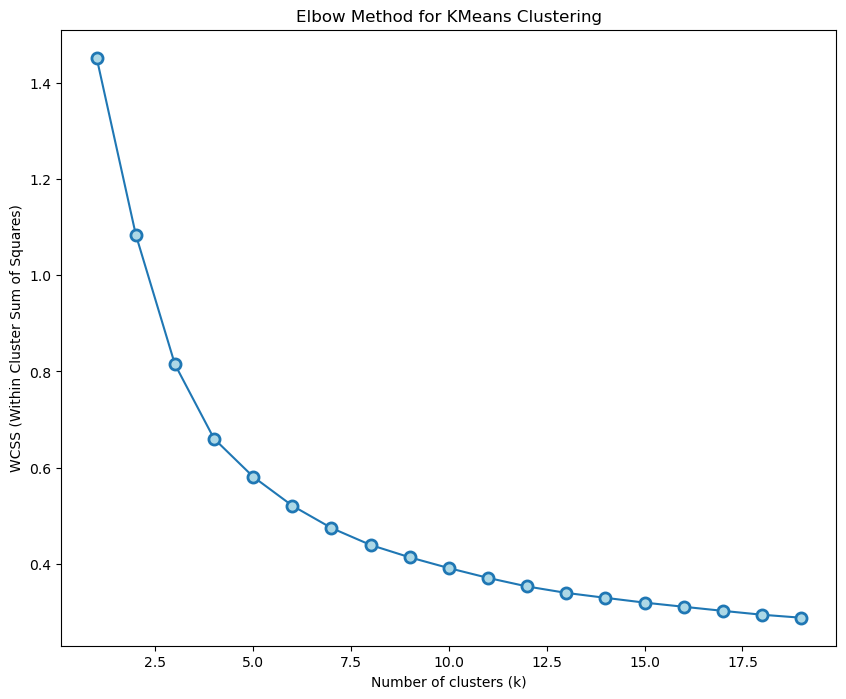

In [36]:
# Plotting WCSS vs k to identify the elbow point
plt.figure(figsize=(10, 8))
plt.plot(k_range, wcss, 'o-', markerfacecolor='lightblue', markeredgewidth=2, markersize=8)
plt.xlabel('Number of clusters (k)')
plt.ylabel('WCSS (Within Cluster Sum of Squares)')
plt.title('Elbow Method for KMeans Clustering')
plt.show()

## Clustering

In [37]:
# Fit the KMeans model
kmeans = KMeans(n_clusters=4, random_state=0).fit(embeddings)

# Get the cluster labels
cluster_labels = kmeans.labels_

# Get the cluster centers
cluster_centers = kmeans.cluster_centers_

df['cluster_kmeans'] = kmeans.predict(embeddings)
df.groupby(['cluster_kmeans']).mean()

,yeojohnson_revenue_in_eur_bin,is_EMEA,is_Webshop,is_industry_FinanceInsuranceRealEstate,is_industry_Manufacturing,is_industry_Other,is_industry_RetailTrade,is_industry_Services,is_industry_WholesaleTrade,license_value_score,customer_value_score
cluster_kmeans,,,,,,,,,,,
0,0.502294,0.759589,0.484493,0.071756,0.135071,0.152138,0.095063,0.446871,0.099101,0.454237,0.407849
1,0.499153,0.757380,0.498421,0.078196,0.141151,0.152959,0.098174,0.431759,0.097762,0.447484,0.403094
2,0.500207,0.756990,0.486517,0.074049,0.135598,0.154721,0.098529,0.436631,0.100472,0.450597,0.404027
3,0.499739,0.755427,0.490572,0.077244,0.133589,0.154459,0.096995,0.438871,0.098842,0.450316,0.404263


In [ ]:
# df.mean()

In [38]:
df.cluster_kmeans.value_counts()

2    44241
3    35744
1    14566
0     5449
Name: cluster_kmeans, dtype: int64

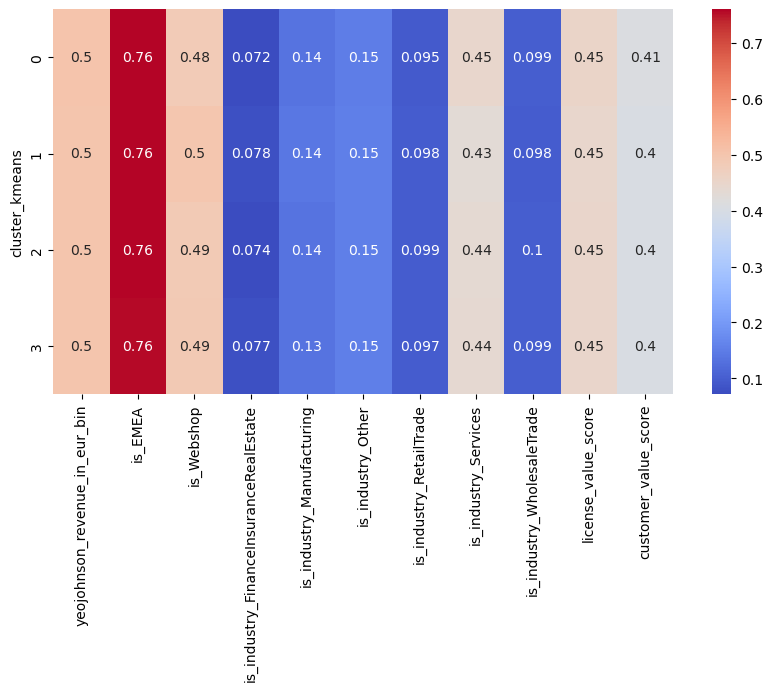

In [39]:
# Visualize the correlation matrix
plt.figure(figsize=(10,5))
sns.heatmap(df.groupby(['cluster_kmeans']).mean(), cmap='coolwarm', annot=True)
plt.show()

In [40]:
clusters=pd.DataFrame(features, columns=features_df.columns)
clusters['label']=kmeans.labels_
polar=clusters.groupby("label").mean().reset_index()
polar=pd.melt(polar,id_vars=["label"])
fig = px.line_polar(polar, r="value", theta="variable", color="label", line_close=True,height=800,width=1400)
fig.show()

## Evaluation

In [41]:
# Calculate Silhouette Score
silhouette_avg = silhouette_score(features_df, cluster_labels)
print(f'Silhouette Score: {silhouette_avg:.3f}')

Silhouette Score: -0.003


In [42]:
# Calculate Davies-Bouldin Index
davies_bouldin_avg = davies_bouldin_score(features_df, cluster_labels)
print(f'Davies-Bouldin Index: {davies_bouldin_avg:.3f}')

Davies-Bouldin Index: 270.729


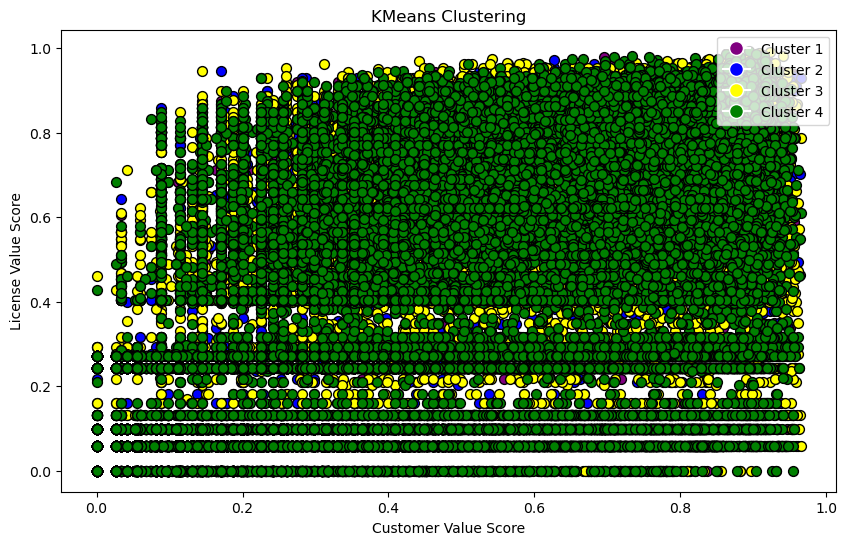

In [43]:
# Define colors for each cluster
cluster_colors = ['purple', 'blue', 'yellow', 'green']

# Plot the clusters using the first two features
plt.figure(figsize=(10, 6))

# Scatter plot of the data points, colored by cluster label
for i in range(kmeans.n_clusters):
    plt.scatter(score_features[:, -2][cluster_labels == i], score_features[:, -1][cluster_labels == i], color=cluster_colors[i], 
                label=f'Cluster {i+1}', marker='o', edgecolor='k', s=50)

# Scatter plot of the data points
# plt.scatter(score_features[:, -2], score_features[:, -1], c=cluster_labels, cmap='viridis', marker='o', edgecolor='k', s=50)

# Scatter plot of the cluster centers
# plt.scatter(cluster_centers[:, -2], cluster_centers[:, -1], c='red', marker='x', s=200, linewidths=3, edgecolor='k', label='Cluster Centers')

# Create custom legend for clusters
legend_elements = [Line2D([0], [0], marker='o', color='w', label=f'Cluster {i+1}', 
                          markerfacecolor=cluster_colors[i], markersize=10) for i in range(kmeans.n_clusters)]
# legend_elements.append(Line2D([0], [0], marker='x', color='w', label='Cluster Centers', 
#                               markerfacecolor='red', markersize=10, linestyle='None', markeredgewidth=2))

# Add titles, labels and legend
plt.legend(handles=legend_elements, loc='upper right')
plt.title('KMeans Clustering')
plt.xlabel('Customer Value Score')
plt.ylabel('License Value Score')

# Show plot
plt.show()